In [1]:
# move workidir to the correct folder
import os
os.chdir("../")


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Custom Libs
from dataset.dataset import Dataset

In [3]:
# Set up which conlumn to use as a target :
# 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
# 'review_scores_communication', 'review_scores_location', 'review_scores_value',

REFERENCE_COlUMN = "review_scores_rating"
BUCKETS = [(0, 4), (4, 4.5), (4.5, 4.8), (4.8, 5)]
OUTLIERS_HIGH = 4.99999
OUTLIERS_LOW = 0


# Other experiments
REFERENCE_COlUMN = "price"
BUCKETS = [(50,100), (100, 200), (200, 300), (300,400), (400,500)]
OUTLIERS_HIGH = 500
OUTLIERS_LOW = 50

# REFERENCE_COlUMN = "price"
# BUCKETS = [(50, 100), (100, 150), (150, 200)]
# OUTLIERS_LOW = 50
# OUTLIERS_HIGH = 200


In [4]:
# Load the precleaned and spearated datset
with open(f'./dataset/train_dataset.pkl', 'rb') as f:
    train_dataset = pd.read_pickle(f)

with open(f'./dataset/test_dataset.pkl', 'rb') as f:
    test_dataset = pd.read_pickle(f)

In [5]:
y_train = train_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_train = train_dataset.getListingsNotEmbeddings()
x_embeddings_train = train_dataset.getListingsEmbeddings()
print("not_embeddings_shape", x_not_embeddings_train.shape)
print("embeddings_shape", x_embeddings_train.shape)

not_embeddings_shape (5598, 146)
embeddings_shape (5598, 2048)


In [6]:
# Apply PCA to non embeddings fields + normalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Note that the PCA and the scaler are kept to be reused in the test
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_train = x_not_embeddings_train.fillna(0)
x_not_embeddings_train_scaled = scaler.fit_transform(x_not_embeddings_train)
x_not_embeddings_train_60 = pca.fit_transform(x_not_embeddings_train_scaled)

In [7]:
#  define X and y for training
X_train = np.concatenate((x_not_embeddings_train_60, x_embeddings_train), axis=1)   

In [8]:
# Load and prepare Test
y_test = test_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_test = test_dataset.getListingsNotEmbeddings()
x_embeddings_test = test_dataset.getListingsEmbeddings()
print("not_embeddings_shape", x_not_embeddings_test.shape)
print("embeddings_shape", x_embeddings_test.shape)

# PCA for dimensionality reduction
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_test = x_not_embeddings_test.fillna(0)
x_not_embeddings_test_scaled = scaler.fit_transform(x_not_embeddings_test)
x_not_embeddings_test_60 = pca.fit_transform(x_not_embeddings_test_scaled)

X_test = np.concatenate((x_not_embeddings_test_60, x_embeddings_test), axis=1)

not_embeddings_shape (1400, 146)
embeddings_shape (1400, 2048)


In [9]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Drop nan values based on target conlumn
empty_target_indexes_train = y_train.notna()
X_train = X_train[empty_target_indexes_train]
y_train = y_train[empty_target_indexes_train]

empty_target_indexes_test = y_test.notna()
X_test = X_test[empty_target_indexes_test]
y_test = y_test[empty_target_indexes_test]

## Appling cutout
not_outliers_idx = y_train <= OUTLIERS_HIGH
not_outliers_idx_2 = y_train[y_train <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_train = X_train[not_outliers_idx][not_outliers_idx_2]
y_train = y_train[not_outliers_idx][not_outliers_idx_2]

not_outliers_idx = y_test <= OUTLIERS_HIGH
not_outliers_idx_2 = y_test[y_test <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_test = X_test[not_outliers_idx][not_outliers_idx_2]
y_test = y_test[not_outliers_idx][not_outliers_idx_2]


In [10]:
# Bucket generations
def bucketizie(x):
    for i in range(len(BUCKETS)):
        start, end = BUCKETS[i]
        if (i == 0): 
            if x >= start and  x<=end: return i
        else:
            if x > start and  x<=end: return i
        
    return len(BUCKETS) -1

y_train_buckets = [bucketizie(val) for val in y_train]
y_test_buckets = [bucketizie(val) for val in y_test]


In [11]:
np.unique(y_train_buckets)

array([0, 1, 2, 3, 4])

In [12]:
# An util function to plot the result of a trained model on the test data
from sklearn import metrics
from lightgbm import LGBMClassifier

def evaluate_and_display(model, x, y):
    y_hat = model.predict(x).round()

    # print reference
    for i in range(len(BUCKETS)):
        start, end = BUCKETS[i]
        print(f"Bucket {i}-> {start}-{end}")
 
    ## Confusion
    cm = metrics.confusion_matrix(y, y_hat)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    ## ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("AUC:", auc)

    # Accuracy
    print("Accuracy:", metrics.accuracy_score(y, y_hat))

    print(metrics.classification_report(y, y_hat))

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


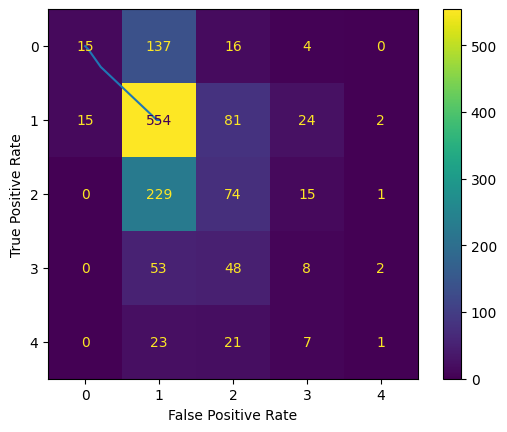

AUC: 0.5444421706060917
Accuracy: 0.49022556390977445
              precision    recall  f1-score   support

           0       0.50      0.09      0.15       172
           1       0.56      0.82      0.66       676
           2       0.31      0.23      0.26       319
           3       0.14      0.07      0.09       111
           4       0.17      0.02      0.03        52

    accuracy                           0.49      1330
   macro avg       0.33      0.25      0.24      1330
weighted avg       0.44      0.49      0.43      1330



In [13]:
model = LGBMClassifier(n_estimators=200, nthread=-1, seed=0)
model.fit(X_train, y_train_buckets)
evaluate_and_display(model, X_test, y_test_buckets)

Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


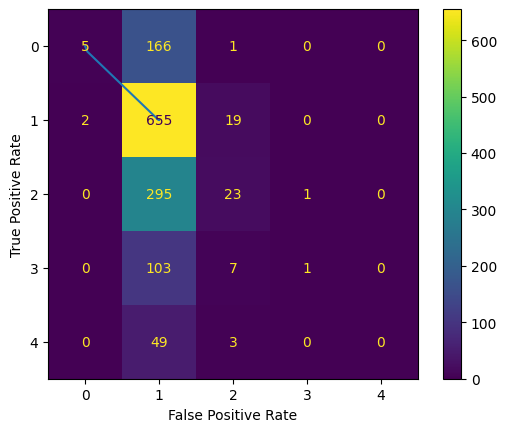

AUC: 0.525498513219786
Accuracy: 0.5142857142857142
              precision    recall  f1-score   support

           0       0.71      0.03      0.06       172
           1       0.52      0.97      0.67       676
           2       0.43      0.07      0.12       319
           3       0.50      0.01      0.02       111
           4       0.00      0.00      0.00        52

    accuracy                           0.51      1330
   macro avg       0.43      0.22      0.17      1330
weighted avg       0.50      0.51      0.38      1330



/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train_buckets)
evaluate_and_display(model, X_test, y_test_buckets)

Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


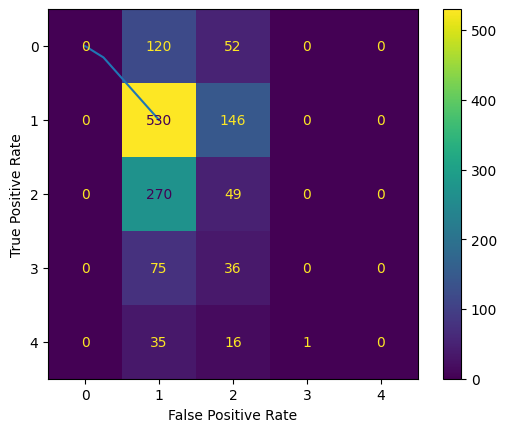

AUC: 0.4525920206877948
Accuracy: 0.43533834586466164
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.51      0.78      0.62       676
           2       0.16      0.15      0.16       319
           3       0.00      0.00      0.00       111
           4       0.00      0.00      0.00        52

    accuracy                           0.44      1330
   macro avg       0.14      0.19      0.16      1330
weighted avg       0.30      0.44      0.35      1330



/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [15]:
from sklearn.svm import SVC
model = SVC(gamma='auto', kernel= "rbf")
model.fit(X_train, y_train_buckets)
evaluate_and_display(model, X_test, y_test_buckets)